In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

---
### Input parameters

In [2]:
# site directories
root_dir = '/home1/scratch/slgentil/parcels/'
site = 'californie'
dl = 4
speed = 5
t_delta=pd.Timedelta(days=10)    # Length of the trajectories

---
### init parameters

In [3]:
run_dir = os.path.join(root_dir, site+"/run/")
simu_name = 'dl'+str(dl)+'.speed'+str(speed)

if site == 'californie':
    lonmin=-127.
    lonmax=-124.
    latmin=34
    latmax=37
bbox = [lonmin, lonmax, latmin, latmax]

---
### Methods

In [4]:
def plot_site(bbox, figsize=(10,10)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, 1, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    ax.add_geometries(gdf_crs['geometry'],
                      crs=crs,
                      facecolor='grey', 
                      edgecolor='black',
                      alpha=0.5,
                     )

    ax.gridlines(draw_labels=True)
    #ax.coastlines(resolution='50m')

    return fig, ax

In [5]:
def plot_pretty(bbox, swot_tracks=False, trails=None, bg_var=None, figsize=(10,10), **kwargs):

    # init figure, axe
    fig, ax = plt.subplots(1, 1, 
                           #subplot_kw={'projection': crs},
                           subplot_kw={'projection': ccrs.PlateCarree()},
                           figsize=figsize,
                          )
    ax.set_extent(bbox)
    # Hide the right and top axis graduation
    #ax.tick_params(labeltop=True, labelright=True)
    #ax.tick_params(labeltop=True, labelright=True)
        
    if bg_var is not None:
        bg_kwargs = kwargs['bg_kwargs']
        bg_var.plot.pcolormesh(ax=ax,x="XC",y="YC",**bg_kwargs)

    
    if swot_tracks is not None:
        # init for swot tracks
        central_lon = (bbox[0]+bbox[1])*0.5
        central_lat = (bbox[2]+bbox[3])*0.5

        polygon = Polygon([(bbox[0], bbox[2]), 
                           (bbox[1], bbox[2]), 
                           (bbox[1], bbox[3]), 
                           (bbox[0], bbox[3]), 
                           (bbox[0], bbox[2]),
                          ])
        
        crs = ccrs.AlbersEqualArea(central_lon, central_lat)
        crs_proj4 = crs.proj4_init
        gdf = tracks["swath"]
        gdf_clipped = gpd.clip(gdf, polygon)
        gdf_crs = gdf_clipped.to_crs(crs_proj4)
        ax.add_geometries(gdf_crs['geometry'],
                          crs=crs,
                          facecolor='grey', 
                          edgecolor='black',
                          alpha=0.5,
                         )
    # set grid lines
    gl = ax.gridlines(draw_labels=True)
    # Hide the right and top axis graduation
    gl.top_labels = False
    gl.right_labels = False
    
    #ax.coastlines(resolution='50m')
    if trails is not None:
        drifter_kwargs = kwargs['drifter_kwargs']
        if trails.index.unique().size>1:
            trails.groupby('trajectory').apply(plot_trajectory, ax=ax, **drifter_kwargs)
        else:
            ax.plot(trails.lon, trails.lat, '-+',**drifter_kwargs)

    return fig, ax

In [6]:
def plot_trajectory(df, 
                    ax=None, 
                    flag_drifters=0,
                    **kwargs,
                   ):
    """ plot single drifter trajectory
    
    Parameters
    ----------
    df: pandas.Dataframe
    ax: pyplot axis, optional
    flag_drifters: int, optional
        used to distinguish drifters 
    **kwargs: optional
        options for plot method
    """
    df = df.sort_index()
    dr_id = int(df['trajectory'].unique()[0])
    dkwargs = dict(ms=1)
    dkwargs.update(kwargs)
    if ax is None:
        fig, ax = plt.subplots(1, 1, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    ax.plot(df.lon, df.lat, **dkwargs)
    return ax

In [7]:
def format_info(t_start, t_end, t_released, t_delta):
    print('start={}  /  end={}  /  released={} / delta={} days'
          .format(t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                  t_released.strftime("%Y-%m-%d:%H"),
                  t_delta.days
                 )
         )

### Load SWOT tracks

In [8]:
tracks = ut.load_swot_tracks()

---
### Load trajectories

In [9]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
df_trails = pa.load_nc(run_dir, index='time', step_tile=simu_name, persist=True).compute().dropna()
#df_trails = df_trails.loc[df_trails.index.dropna()]

---
### Load llc

In [10]:
ds_llc = xr.open_dataset(os.path.join(run_dir, "data_000/llc.nc")).chunk(chunks={"time": 1})

---
### Plots

Plot last t_delta days of the simulation

In [11]:
t_start = df_trails.index.min()
t_end = df_trails.index.max()
#t_delta=pd.Timedelta(days=10)

# Compute the first time where all the drifters are released
nb_flt = df_trails['trajectory'].unique().size      # Compute number of released drifters
_df = pd.Index(df_trails.index).value_counts()        # get number of rows per time
_df = _df[_df == nb_flt]                            # Keep lines with nb_flt number of rows
t_released = _df.index.min()                              # Keep  the min date

format_info(t_start, t_end, t_released, t_delta)

start=2011-11-15:00  /  end=2011-12-15:01  /  released=2011-11-16:14 / delta=10 days


(<Figure size 720x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'time = 2011-11-15, niter = 228096'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

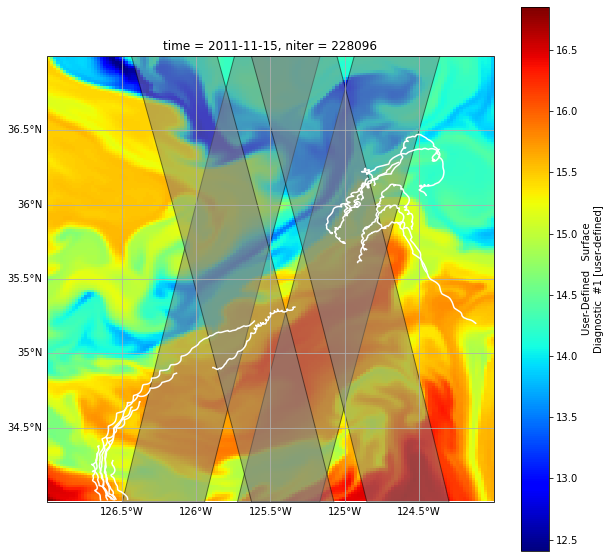

In [12]:
kwargs = dict(
              drifter_kwargs={"color": "white"},
              bg_kwargs = {'vmin': None,'vmax': None, 'cmap':'jet'}
             )

trails = df_trails.loc[(df_trails.index>=t_end-t_delta)&(df_trails.index<=t_end)]
bg_var = ds_llc['SST'].sel(time=t_start)

plot_pretty(bbox, swot_tracks=tracks, trails=trails, bg_var=bg_var, figsize=(10,10), **kwargs)

Plot time of the last released drifter

(<Figure size 720x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'time = 2011-11-16T14:00:00, niter = 233568'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

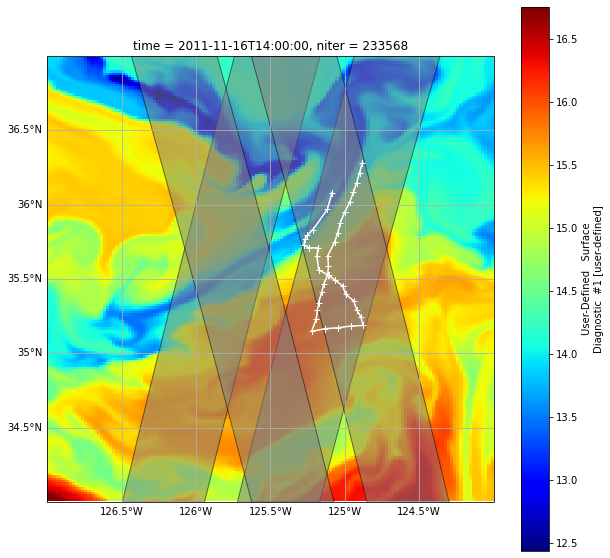

In [13]:
trails = df_trails.loc[(df_trails.index==t_released)]
bg_var = ds_llc['SST'].sel(time=t_released)
plot_pretty(bbox, swot_tracks=tracks, trails=trails, bg_var=bg_var, figsize=(10,10), **kwargs)